## DV1597 Assignment 1

Namn

***

#### Initialize

In [24]:
# Import packages
import pandas as pd
import matplotlib.pyplot as mpl
import seaborn as sb
import numpy as np
import math
import scipy.stats as stats


In [26]:
# Load dataset
df_original = pd.read_csv('SMHI_Data.csv')
df_original

,Datum,Tid (UTC),Lufttemperatur
0,2010-03-01,00:00:00,2.0
1,2010-03-01,01:00:00,2.2
2,2010-03-01,02:00:00,2.2
3,2010-03-01,03:00:00,1.7
4,2010-03-01,04:00:00,1.7
...,...,...,...
122851,2024-01-01,02:00:00,3.9
122852,2024-01-01,03:00:00,3.9
122853,2024-01-01,04:00:00,3.7
122854,2024-01-01,05:00:00,3.6


***

### Part 1

#### Q1
**Explain the data cleaning steps you consider for analyzing the provided dataset. You must motivate and describe why, how, and in which order you are going to apply the selected steps to the dataset. Note that you should consider applying your proposed data cleaning steps on the dataset to answer Q2-Q11.**

Firstly we will look at the dataset and remove all duplicates in it. Then we want to remove all the missing values. Some missing values have an entry in the csv-file, but is missing the temperature data, while some timestamps are not found at all in the data. The strategy here is to insert all timestamps that are missing, with no temperature data, and then add an estimated temperature for every missing instance.

***

#### Q2
**Does the dataset contain any missing values? If so, how many in both absolute terms and percentages? Reflect on the number of missing values. Do you regard it as much or not?**

Yes, yes.

***

#### Q3
**Which strategy was used for handling the missing values? Motivate why you consider the selected strategy the most suitable for this task.**

Good strategy.

***

### Find missing timestamps

Out first step is to look at every row in the dataset, and find if any timestamp is missing from it. For example if for a date, the time 00:00:00 and 02:00:00 exists, but not 01:00:00. We also add all the timestamps that are missing to the dataframe.

In [27]:
df = df_original.copy()

# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

# Convert date and time to one datetime column
df['Time'] = df['Datum']+" "+df['Tid (UTC)']
df['Time'] = pd.to_datetime(df['Time'])

# Remove old time data
df = df.drop('Datum', axis=1)
df = df.drop('Tid (UTC)',axis=1)

# Create a date range from first to last timestamp
start = df.iloc[0]
end = df.iloc[len(df)-1]
dates = pd.date_range(start=start['Time'], end=end['Time'], freq='1h')

# Count missing timestamps
missing = len(dates)-len(df)
print("Missing timestamps:",missing)

# Add missing timestamps
df = df.set_index('Time').reindex(dates).reset_index()
df.columns = ['Time', 'Lufttemperatur']

Missing timestamps: 694


We found and added a total of 694 missing timestamps.

### Missing temperature values
Now we look for instances where the temperature data is missing.

In [28]:
# Count NaN values for each column
na_values = df.isna().sum()
na_temp = na_values['Lufttemperatur']
na_p = round(100*(na_temp/len(df)),2)

print("NaN temperatures:",na_temp)
print("NaN temperatures percentage:",na_p, '%')

NaN temperatures: 7931
NaN temperatures percentage: 6.54 %


### Estimating missing values

In [29]:
df['Lufttemperatur'] = df['Lufttemperatur'].interpolate().round(1)
df.to_csv('data.csv', index=False)

***
#### Q4

**Calculate the following statistics for the air temperature values in the dataset: minimum value, maximum value, sample mean, Q1/Q2/Q3 quartiles, sample standard deviation, 95% confidence interval of the mean**

In [30]:
temps = df_original['Lufttemperatur']
print("Min:",temps.min())
print("Max:",temps.max())
print("Mean:",round(temps.mean(),3))

print("\nQuartiles:")
print("Q1 (25%):",temps.quantile(0.25))
print("Q2 (50%):",temps.quantile(0.5))
print("Q3 (75%):",temps.quantile(0.75))

print("\nStandard deviation",round(temps.std(),3))

# 95% confidence interval: mean +- margin of error
# margin of error = critical t-value * standard deviation / sqrt(sample size)

critical_t_value = stats.t.ppf(0.05 / 2, df['Lufttemperatur'].count() - 1)
margin_of_error = critical_t_value * df['Lufttemperatur'].std() / (df['Lufttemperatur'].count() ** 0.5)

print("\nConfidence interval: ", df['Lufttemperatur'].mean().round(3), " +- ", abs(margin_of_error).round(3))


Min: -19.2
Max: 38.6
Mean: 9.435

Quartiles:
Q1 (25%): 4.1
Q2 (50%): 9.1
Q3 (75%): 15.3

Standard deviation 6.978

Confidence interval:  9.441  +-  0.039


***
#### Q5
**Plot all available air temperature data as a line plot with dates on the x-axis.**


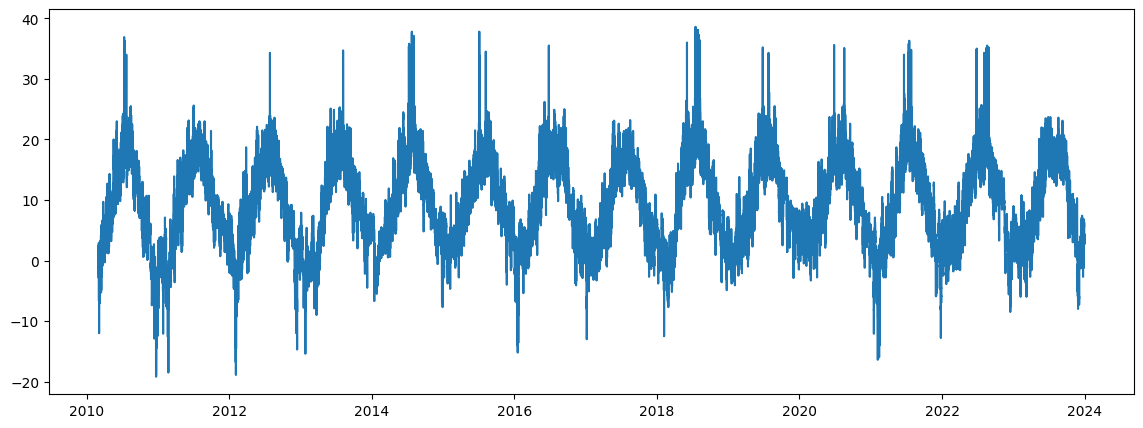

In [31]:
fig = mpl.figure(figsize=(14, 5))
ax = fig.add_subplot(1,1,1)

ax.plot(df['Time'],df['Lufttemperatur'], )
mpl.show()

***

#### Q6
**Rank the overall temperature per month, sort from the coldest to the warmest. List the top ten (10) coldest months in the dataset. Format the output as: YEAR/Month: temp, e.g.“2010/January: -5.0”**

### Part 2 (D)

Q7. Which distribution is suitable to consider to fit the air temperature data? How well does the data follow that distribution given some measure, e.g., p-value?

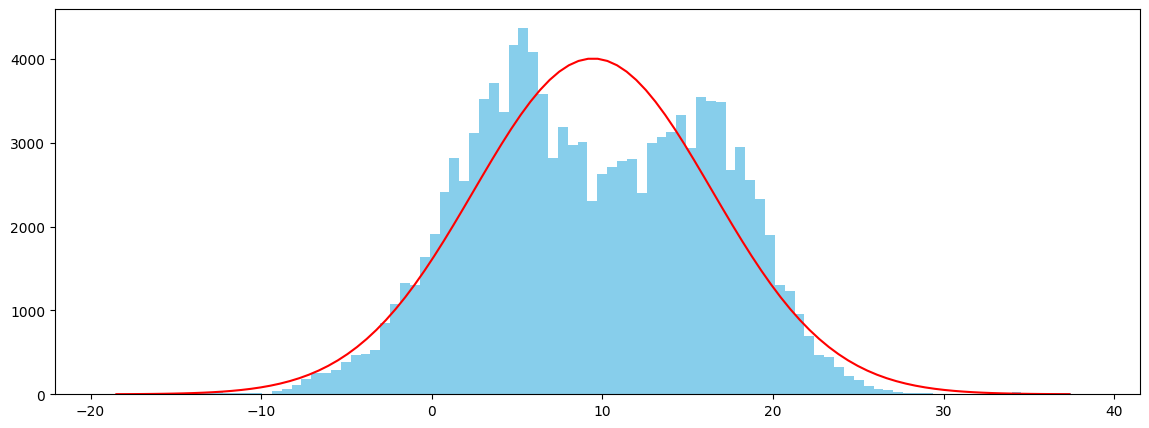

In [32]:
fig = mpl.figure(figsize=(14,5))
ax = fig.add_subplot()
num_bins = 100
ax.hist(df['Lufttemperatur'], bins=num_bins, label="Datatata", linewidth=3, color='skyblue')

bin_width = (df['Lufttemperatur'].max() - df['Lufttemperatur'].min()) / num_bins
mean = df['Lufttemperatur'].mean()
std = df['Lufttemperatur'].std()

x = np.linspace(mean - 4*std, mean + 4*std, 100)

mpl.plot(x, stats.norm.pdf(x, mean, std)*len(df)*bin_width, color='red')
mpl.show()

Normally disitribyted? no

***

### Part 3 (C)

### Q8
Do you regard any of the air temperature measures in the dataset to be extreme values/outliers? If so, how many values? Motivate why you
consider these values as anomalies.

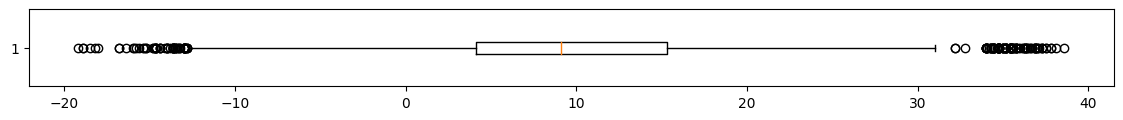

In [33]:
fig_o = mpl.figure(figsize=(14,1))
ax = fig_o.add_subplot(1,1,1)
ax.boxplot(df['Lufttemperatur'], vert=False)
mpl.show()

mean = df['Lufttemperatur'].mean()
std = df['Lufttemperatur'].std()

***

### Q9
Calculate the mean temperature for each day in the year 2023 and then plot those means using a line plot with dates on the x-axis.

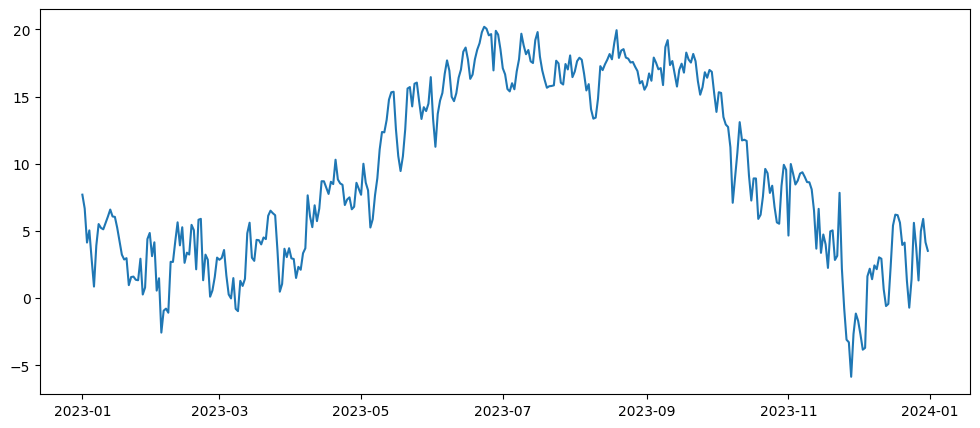

In [34]:
# Slicing 2023 rows
df_2023 = df.loc[112536:121295].copy()

# Add and group by date
df_2023['Date'] = df['Time'].dt.date
mean_values = df_2023.groupby('Date')['Lufttemperatur'].mean().reset_index()

# Create line diagram
fig = mpl.figure(figsize=(12, 5))
ax = fig.add_subplot(1,1,1)
ax.plot(mean_values['Date'],mean_values['Lufttemperatur'])
mpl.show()

***

### Part 4 (B)

Q10. Rank the overall temperature per two (2) consecutive months starting with the warmest 2-month period first, e.g., (Y1M1+Y1M2)/2, (Y1M2+Y1M3)/2,... (Y1M11+Y1M1)/2, (Y1M12+Y2M1)/2,.... After that, you should sort those means from highest to lowest and list the ten (10) warmest 2-month periods all together in the dataset.

***

### Part 5 (A)

Q11. Calculate the 95% confidence intervals (CI) for the mean of each daily average in Q9 and add it to the line plot that shows the mean values of
each day of the year 2023. You can, for example, solve this by plotting the upper and lower bounds as lines above and below the mean line in your
plot. Another more nicely looking solution is to visualize the CI as shades around the mean line in your plot.